<a href="https://colab.research.google.com/github/ykato27/Computer_Vision/blob/main/Classification_CelebA_googlecolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CelebA画像を対象に画像分類モデルを作成
* Convolution層を持つニューラルネットを実装

#### CelebA (Large-scale CelebFaces Attributes) データセットのダウンロードと展開（解凍）
1. Webブラウザで下記URLを開く
[http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
2. 「[Google Drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8)」をクリック
3. 「[img](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg)」ディレクトリの下の「img_align_celeba.zip」をダウンロード
4. フォルダ「data」の直下で「img_align_celeba.zip」を解凍

In [1]:
# ライブラリーのインストール
import glob
import os
from os.path import join
import pathlib
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


%matplotlib inline

In [2]:
# google driveのマウント
from google.colab import drive


drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!unzip "drive/MyDrive/CelebA_dataset/img_align_celeba.zip"

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 extracting: img_align

#### データの確認

In [4]:
# CelebAデータセットのディレクトリを指定
path_dir = Path("img_align_celeba")

# glob関数により取得した jpg ファイルの一覧
sorted(path_dir.glob("*.jpg"))[:10]

[PosixPath('img_align_celeba/000001.jpg'),
 PosixPath('img_align_celeba/000002.jpg'),
 PosixPath('img_align_celeba/000003.jpg'),
 PosixPath('img_align_celeba/000004.jpg'),
 PosixPath('img_align_celeba/000005.jpg'),
 PosixPath('img_align_celeba/000006.jpg'),
 PosixPath('img_align_celeba/000007.jpg'),
 PosixPath('img_align_celeba/000008.jpg'),
 PosixPath('img_align_celeba/000009.jpg'),
 PosixPath('img_align_celeba/000010.jpg')]

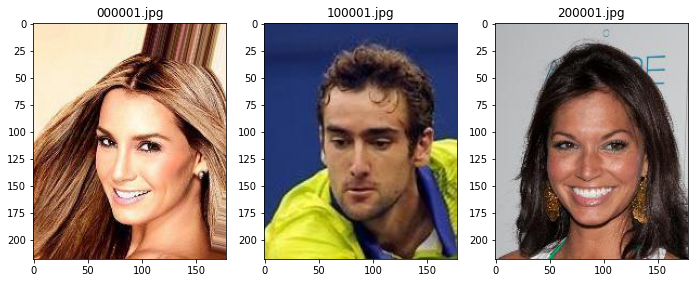

In [5]:
plt.figure(figsize=(20, 20))
for i, path_img in enumerate(sorted(path_dir.glob("*00001.jpg"))):
    name_img = path_img.name
    img = Image.open(path_img)
    plt.subplot(4, 5, i + 1)
    plt.title(name_img)
    plt.imshow(img)

## 画像のリサイズ
ニューラルネットに入力する画像をリサイズする。
画像のサイズをヒストグラムを書いて確認。

Text(0, 0.5, 'freq')

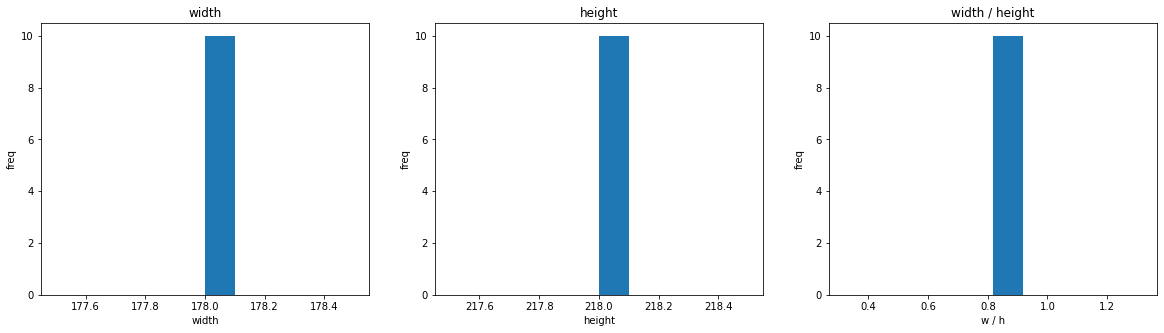

In [6]:
# 画像サイズを集計
list_w, list_h, list_ratio = [], [], []

for path_img in path_dir.glob("*.jpg"):
    img = Image.open(path_img)
    w, h = img.size
    list_w.append(w)
    list_h.append(h)
    list_ratio.append(w / h)

# ヒストグラムの表示
plt.figure(figsize=(20, 5))
# width
plt.subplot(1, 3, 1)
plt.hist(list_w, bins=10, density=True)
plt.title("width")
plt.xlabel("width")
plt.ylabel("freq")

# width
plt.subplot(1, 3, 2)
plt.hist(list_h, bins=10, density=True)
plt.title("height")
plt.xlabel("height")
plt.ylabel("freq")

# rate
plt.subplot(1, 3, 3)
plt.hist(list_ratio, bins=10, density=True)
plt.title("width / height")
plt.xlabel("w / h")
plt.ylabel("freq")

2の累乗を約数に含むようにサイズを設定。「224 * 224」に設定。

In [7]:
def load_image(path_img, size=(224, 224)):
    img = Image.open(path_img)

    # 短辺長を基準とした正方形の座標を得る
    x_center = img.size[0] // 2
    y_center = img.size[1] // 2
    half_short_side = min(x_center, y_center)
    x0 = x_center - half_short_side
    y0 = y_center - half_short_side
    x1 = x_center + half_short_side
    y1 = y_center + half_short_side

    img = img.crop((x0, y0, x1, y1))
    img = img.resize(size)
    img = np.array(img, dtype=np.float32)
    return img

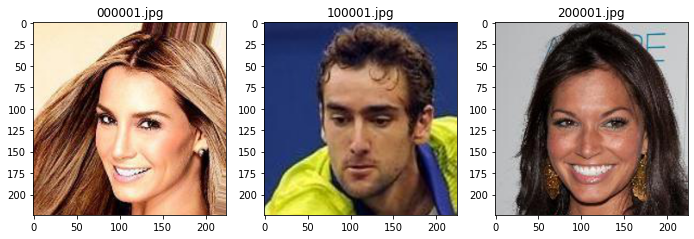

In [8]:
# リサイズ後の画像を確認
plt.figure(figsize=(20, 20))
for i, path_img in enumerate(sorted(path_dir.glob("*00001.jpg"))):
    name_img = path_img.name
    img = load_image(path_img)
    plt.subplot(4, 5, i + 1)
    plt.title(name_img)
    plt.imshow(img / 255)  # matplotlib で float32型の数値を適切に表示するために 0-1の間に収めます。

## CelebAのデータセットを抽出
今回は下記4パターンの人を抽出します
* 笑っている男性
* 笑っていない男性
* 笑っている女性
* 笑っていない女性

In [9]:
# outputディレクトリの指定
output_dir = f"drive/MyDrive/CelebA_dataset/"

# フォルダをリストで作成
pass_list = [f"00_smiling_male/", f"01_Nonsmiling_male/"]

for path in pass_list:
    path_train_data = join(output_dir, path)
    if not os.path.exists(path_train_data):
        os.makedirs(path_train_data)

In [10]:
count = 0

with open(
    "drive/MyDrive/CelebA_dataset/list_attr_celeba_ref.txt", "r"
) as f:  ### 属性ファイルを開く
    for i in range(202599):  # 全部で202,599枚処理する
        line = f.readline()  # 1行データ読み込み
        line = line.split()  # データを分割
        count = count + 1
        print(count)

        # 笑っている男性
        if (
            line[3] == "1"
            and line[16] == "-1"
            and line[21] == "1"
            and line[32] == "1"
            and line[36] == "-1"
            and line[40] == "1"
        ):
            image = Image.open("img_align_celeba/" + line[0])
            image.save(output_dir + pass_list[0] + line[0])

        # 笑っていない男性
        elif (
            line[3] == "1"
            and line[16] == "-1"
            and line[21] == "1"
            and line[32] == "-1"
            and line[36] == "-1"
            and line[40] == "1"
        ):
            image = Image.open("img_align_celeba/" + line[0])
            image.save(output_dir + pass_list[1] + line[0])

        # 笑っている女性
    #  elif line[3]=="1" and line[16]=="-1" and line[21]=="-1" and line[32]=="1" and line[36]=="-1" and line[40]=="1":
    #     image = Image.open("img_align_celeba/"+line[0])
    #     image.save(output_dir + pass_list[2] + line[0])

    # 笑っていない女性
    #  elif line[3]=="1" and line[16]=="-1" and line[21]=="-1" and line[32]=="-1" and line[36]=="-1" and line[40]=="1":
    #     image = Image.open("img_align_celeba/"+line[0])
    #     image.save(output_dir + pass_list[3] + line[0])

ストリーミング出力は最後の 5000 行に切り捨てられました。
197600
197601
197602
197603
197604
197605
197606
197607
197608
197609
197610
197611
197612
197613
197614
197615
197616
197617
197618
197619
197620
197621
197622
197623
197624
197625
197626
197627
197628
197629
197630
197631
197632
197633
197634
197635
197636
197637
197638
197639
197640
197641
197642
197643
197644
197645
197646
197647
197648
197649
197650
197651
197652
197653
197654
197655
197656
197657
197658
197659
197660
197661
197662
197663
197664
197665
197666
197667
197668
197669
197670
197671
197672
197673
197674
197675
197676
197677
197678
197679
197680
197681
197682
197683
197684
197685
197686
197687
197688
197689
197690
197691
197692
197693
197694
197695
197696
197697
197698
197699
197700
197701
197702
197703
197704
197705
197706
197707
197708
197709
197710
197711
197712
197713
197714
197715
197716
197717
197718
197719
197720
197721
197722
197723
197724
197725
197726
197727
197728
197729
197730
197731
197732
197733
197734
197735
197736
197737
19

## バッチ作成関数の実装
* ミニバッチを生成する関数を作成。
* 画像のパスを受け取り、入力データ:x_batch, 教師ラベル:t_batchを返す関数。
* 教師ラベルはフォルダ名から計算。

In [11]:
def make_batch(list_path_img):
    x_batch = []
    t_batch = []
    for path_img in list_path_img:
        img = load_image(path_img)
        img = np.array(img, dtype=np.float32)
        img = img.transpose(2, 0, 1)
        x_batch.append(img)
        t = int(str(path_img).split("/")[3][:2])
        t_batch.append(t)
    return torch.tensor(x_batch), torch.tensor(t_batch)

In [12]:
list_path_img = [
    output_dir + "00_smiling_male/" + "000012.jpg",
    output_dir + "00_smiling_male/" + "000023.jpg",
]
x_batch, t_batch = make_batch(list_path_img)

In [13]:
print(list_path_img)
print(x_batch.shape)
print(t_batch)

['drive/MyDrive/CelebA_dataset/00_smiling_male/000012.jpg', 'drive/MyDrive/CelebA_dataset/00_smiling_male/000023.jpg']
torch.Size([2, 3, 224, 224])
tensor([0, 0])


## モデルの作成
* nn.Moduleというクラスを継承したクラスとしてモデルを定義。
* 3チャネルの入力画像を、Convolution 3層により 16 -> 32 -> 64 チャンネルの特徴マップに変換し、最後に全結合層により4次元のベクトルに変換するネットワークを定義。
* Convolution層の直後にはバッチ正則化を行い活性化関数 relu に通す。

In [14]:
class Model(nn.Module):
    def __init__(self):
        # スーパークラス（Module クラス）の初期化メソッドを実行
        super().__init__()

        self.c0 = nn.Conv2d(
            in_channels=3,  # 入力は3チャネル
            out_channels=16,  # 出力は16チャネル
            kernel_size=3,  # カーネルサイズは3*3
            stride=2,  # 1pix飛ばしでカーネルを移動
            padding=1,
        )  # 画像の外側1pixを埋める

        self.c1 = nn.Conv2d(
            in_channels=16,  # 入力は16チャネル
            out_channels=32,  # 出力は32チャネル
            kernel_size=3,  # カーネルサイズは3*3
            stride=2,  # 1pix飛ばしでカーネルを移動
            padding=1,
        )  # 画像の外側1pixを埋める

        self.c2 = nn.Conv2d(
            in_channels=32,  # 入力は32チャネル
            out_channels=64,  # 出力は64チャネル
            kernel_size=3,  # カーネルサイズは3*3
            stride=2,  # 1pix飛ばしでカーネルを移動
            padding=1,
        )  # 画像の外側1pixを埋める

        self.bn0 = nn.BatchNorm2d(num_features=16)  # c0用のバッチ正則化
        self.bn1 = nn.BatchNorm2d(num_features=32)  # c1用のバッチ正則化
        self.bn2 = nn.BatchNorm2d(num_features=64)  # c2用のバッチ正則化

        self.fc = nn.Linear(
            in_features=64 * 28 * 28, out_features=4  # 入力サイズ
        )  # 各クラスに対応する4次元のベクトルに変換

    def __call__(self, x):  # 入力から出力を計算するメソッドを定義
        h = F.relu(self.bn0(self.c0(x)))
        h = F.relu(self.bn1(self.c1(h)))
        h = F.relu(self.bn2(self.c2(h)))
        h = h.view(-1, 64 * 28 * 28)
        y = self.fc(h)  # 全結合層
        return y

## モデルを生成

In [15]:
model = Model()
model.modules

<bound method Module.modules of Model(
  (c0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (c1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=50176, out_features=4, bias=True)
)>

## モデルの挙動確認

In [16]:
!nvidia-smi

Mon Jan 25 12:25:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
# GPUを使用できる設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (c0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (c1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=50176, out_features=4, bias=True)
)

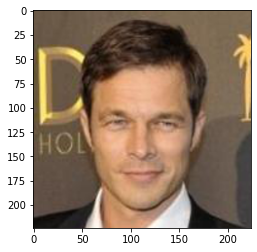

In [18]:
path_img = output_dir + "00_smiling_male/" + "000033.jpg"
img = load_image(path_img)
plt.imshow(img / 255)

* この画像をモデルに通す。
* データを、PyTorchのモデルが入力画像に要求する（バッチ、チャネル、縦、横）という次元に合わせるために、np.newaxis によりバッチ次元として１次元目を挿入し、transpose メソッドにより次元の順番を変える。

In [19]:
img = np.array(img, dtype=np.float32)
img_ = img[np.newaxis].transpose(0, 3, 1, 2)
img_.shape

(1, 3, 224, 224)

In [20]:
x = torch.from_numpy(img_)
x = x.to(device)

In [21]:
model(x)

tensor([[-0.2852, -0.2660,  0.4112,  0.6463]], device='cuda:0',
       grad_fn=<AddmmBackward>)

## モデルの学習

In [22]:
# 一回のパラメータ更新に使うデータ数
size_batch = 64

# 学習データの学習回数
n_epoch = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# ロスと精度を保存するリスト（訓練用・テスト用）
list_loss_train = []
list_loss_test = []
list_acc_train = []
list_acc_test = []

In [23]:
# データの分割
data_train = []
data_test = []

for path in pass_list:
    path_dir_data = Path(output_dir + path)
    list_path_img = sorted(list(path_dir_data.glob("*.jpg")))
    count = 0
    division_point = int(len(list_path_img) * 0.9)  # 学習データを90%、評価データを10%
    for path_img in list_path_img:
        count = count + 1
        if count < division_point:  # division_pointより小さいときは学習データに割り振る。
            data_train.append(path_img)
        else:  # division_pointより大きいときは評価データに割り振る。
            data_test.append(path_img)

In [24]:
# データ数の確認
len(data_train), len(data_test)

(18038, 2008)

In [25]:
# データの型を変更
data_train = np.array(data_train)
data_test = np.array(data_test)

In [28]:
for epoch in range(n_epoch):
    print("-----------------------------------------")
    print("epoch: {}".format(epoch))
    print("train")
    perm = np.random.permutation(len(data_train))
    sum_loss = 0.0
    sum_acc = 0.0
    # 訓練
    for i in range(0, len(perm), size_batch):
        # ミニバッチの用意
        x_batch, t_batch = make_batch(data_train[perm[i : i + size_batch]])
        x_batch = x_batch.to(device)
        t_batch = t_batch.to(device)

        # 順伝播
        y = model(x_batch)
        loss = F.cross_entropy(y, t_batch)

        # 逆伝播
        opt.zero_grad()
        loss.backward()

        # パラメータ更新
        opt.step()

        # ロスと精度を蓄積
        sum_loss += loss.item()
        sum_acc += (y.max(1)[1] == t_batch).sum().item()

        # 進捗を表示
        print(i, "/", len(perm), end="\r")
        sys.stdout.flush()

    mean_loss = sum_loss / len(data_train)
    mean_acc = sum_acc / len(data_train)
    list_loss_train.append(mean_loss)
    list_acc_train.append(mean_acc)
    print("- mean loss:", mean_loss)
    print("- mean accuracy:", mean_acc)

    # Evaluate
    print("test")
    sum_loss = 0.0
    sum_acc = 0.0
    with torch.no_grad():
        for i in range(0, len(data_test), size_batch):
            x_batch, t_batch = make_batch(data_test[i : i + size_batch])
            x_batch = x_batch.to(device)
            t_batch = t_batch.to(device)

            # forward
            y = model(x_batch)
            loss = F.cross_entropy(y, t_batch)

            sum_loss += loss.item()
            sum_acc += (y.max(1)[1] == t_batch).sum().item()

    mean_loss = sum_loss / len(data_test)
    mean_acc = sum_acc / len(data_test)
    list_loss_test.append(mean_loss)
    list_acc_test.append(mean_acc)
    print("- mean loss:", mean_loss)
    print("- mean accuracy:", mean_acc)

-----------------------------------------
epoch: 0
train
- mean loss: 0.02675062772380181
- mean accuracy: 0.766825590420224
test
- mean loss: 0.00442103422673575
- mean accuracy: 0.8829681274900398
-----------------------------------------
epoch: 1
train
- mean loss: 0.004367192734409983
- mean accuracy: 0.8801419226078279
test
- mean loss: 0.003837309684975451
- mean accuracy: 0.9063745019920318
-----------------------------------------
epoch: 2
train
- mean loss: 0.0038302138043799466
- mean accuracy: 0.8966071626566138
test
- mean loss: 0.0038553219236641292
- mean accuracy: 0.898406374501992
-----------------------------------------
epoch: 3
train
- mean loss: 0.0035412516413942806
- mean accuracy: 0.9055882026832243
test
- mean loss: 0.003732779092967985
- mean accuracy: 0.9073705179282868
-----------------------------------------
epoch: 4
train
- mean loss: 0.0034110902788263954
- mean accuracy: 0.9096352145470673
test
- mean loss: 0.003604163360073272
- mean accuracy: 0.9108565

## 結果の表示

正解率の推移

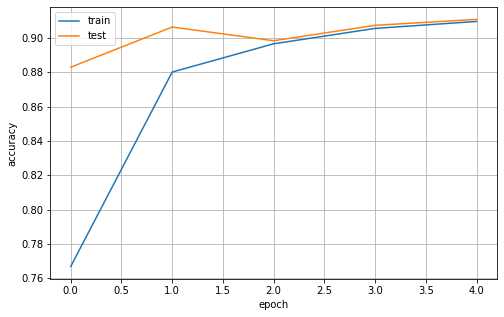

In [29]:
# Accuracy
plt.figure(figsize=(8, 5))
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(list_acc_train)
plt.plot(list_acc_test)
plt.legend(["train", "test"])
plt.show()

Lossの推移

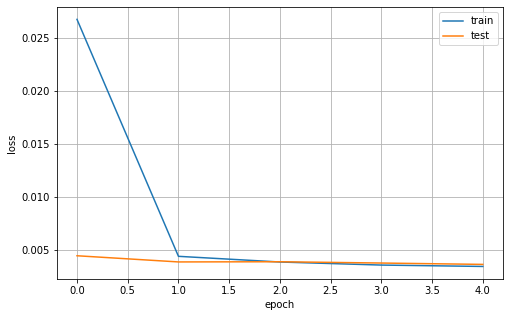

In [30]:
# Loss
plt.figure(figsize=(8, 5))
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(list_loss_train)
plt.plot(list_loss_test)
plt.legend(["train", "test"])
plt.show()

Confusion Matrix

In [31]:
ys = []
ts = []
for i in range(0, len(data_test), size_batch):
    x_batch, t_batch = make_batch(data_test[i : i + size_batch])
    x_batch = x_batch.to(device)
    t_batch = t_batch.to(device)

    y = model(x_batch)
    y = torch.argmax(y, dim=1)  # 確率の最大のインデックスを取得
    ys.append(y.cpu())
    ts.append(t_batch.cpu())

ys = torch.cat(ys, dim=0)
ts = torch.cat(ts, dim=0)

In [32]:
import itertools

# confusion matrixを表示するための関数
from sklearn import metrics


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [33]:
confmat = confusion_matrix(ys, ts)
confmat

array([[879,  91],
       [ 88, 950]])

In [34]:
classes = ["smiling_male", "Nosmiling_male"]

Normalized confusion matrix
[[0.90618557 0.09381443]
 [0.08477842 0.91522158]]


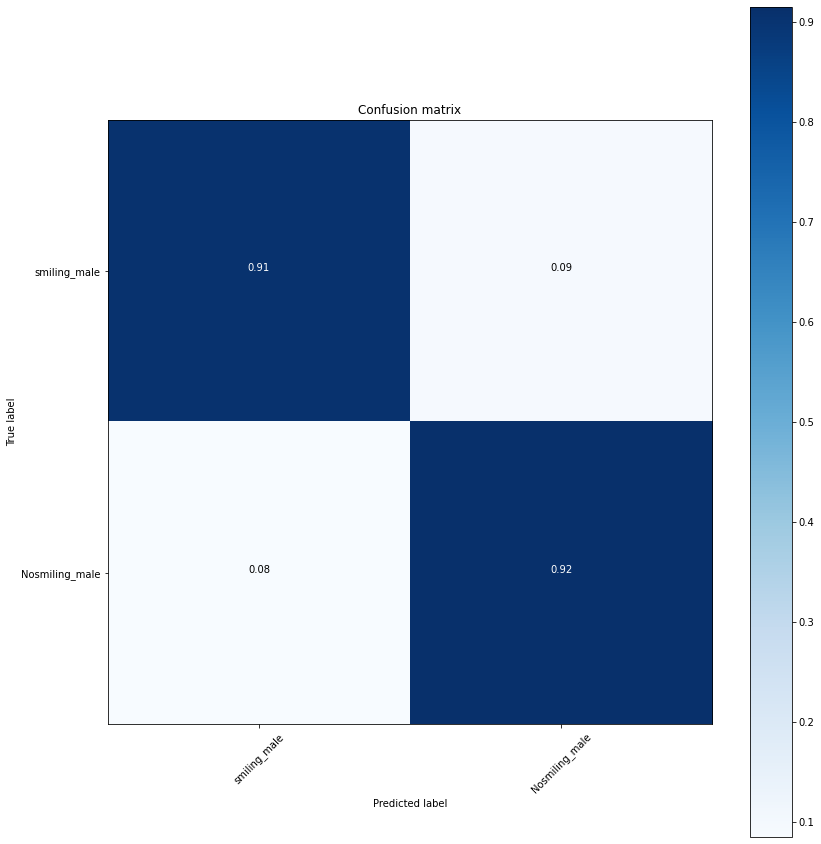

In [35]:
plt.figure(figsize=(12, 12))
plot_confusion_matrix(confmat, classes=classes, normalize=True)